# Optimizing Strategy Parameters

In [ ]:
???

<table style="width:100%; height:90%">
      <tr>
    <th>Parametrize the Strategy</th>
    <th>Optimizing Limits' Parameters</th>
  </tr>
  <tr>
    <td><img src="src/07_Code_Regression Strategy Limits X.png" alt="Parametrize the Strategy" style="width:100%"></td>
    <td><img src="src/07_Table_Optimize BG Default Defaults.png" alt="Optimizing Limits' Parameters" style="width:100%"></td>
  </tr>
</table>

## Load the model

In [80]:
import pickle

with open('models/my_regression.pkl', 'rb') as f:
    model_dt = pickle.load(f)

model_dt

/home/remco/PythonDocuments/practical-python-for-algorithmic-trading-4403633/venv/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


DecisionTreeRegressor(max_depth=15)

## Load the data

In [82]:
import pandas as pd
df = pd.read_excel('data/microsoft-linkedin-processed.xlsx' , index_col=0)
df.index = pd.to_datetime(df.index)


# Simple Investment Strategy

### Create Strategy class

In [83]:
from backtesting import Strategy, Backtest

In [84]:
class Regression(Strategy):
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > 0 and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < 0 and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Create Backtest class

In [86]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

In [22]:
bt = Backtest(df_explanatory, Regression,
              cash=10000, commission=.002, exclusive_orders=True)

### Run backtesting with specific values

In [23]:
results = bt.run()


### Interpret backtesting results

In [24]:
results.to_frame(name='Values').loc[:'Return [%]']

,Values
Start,2016-12-01 00:00:00
End,2024-11-08 00:00:00
Duration,2899 days 00:00:00
Exposure Time [%],99.8999
Equity Final [$],2209827.825089
Equity Peak [$],2210399.19899
Return [%],21998.278251


## Parametrize the Investment Strategy

### Create Strategy class

In [69]:
## split in test and train
df_train = df_explanatory.loc["2016-12-01":"2023-12-31",:].copy() 
df_test = df_explanatory.loc["2024-01-01":,:].copy() 
df_test

,Open,High,Low,Close,Volume
Price,,,,,
2024-01-02,373.859985,375.899994,366.769989,370.869995,25258600
2024-01-03,369.010010,373.260010,368.510010,370.600006,23083500
2024-01-04,370.670013,373.100006,367.170013,367.940002,20901500
2024-01-05,368.970001,372.059998,366.500000,367.750000,20987000
2024-01-08,369.299988,375.200012,369.010010,374.690002,23134000
...,...,...,...,...,...
2024-11-04,409.799988,410.420013,405.570007,408.459991,19672300
2024-11-05,408.369995,414.899994,408.079987,411.459991,17626000
2024-11-06,412.420013,420.450012,410.519989,420.179993,26681800


In [70]:
from backtesting import Strategy, Backtest

In [71]:
class Regression(Strategy):
    limit_buy = 0
    limit_sell = 0
    
    
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

### Create Backtest class

In [72]:
bt = Backtest(df_explanatory, Regression,
              cash=10000, commission=.002, exclusive_orders=True)
results = bt.run()
results["Return [%]"]


21998.27825088909

## Optimize backtesting with multiple combinations

In [73]:
list_limits_buy = list(range(0, 10, 1))
list_limits_buy

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [74]:
list_limits_sell = list(range(0, -10, -1))
list_limits_sell

[0, -1, -2, -3, -4, -5, -6, -7, -8, -9]

In [75]:
%%time

results = bt.optimize(
    limit_buy = list_limits_buy, limit_sell = list_limits_sell,
        maximize='Return [%]', return_heatmap=True
)

CPU times: user 3.65 s, sys: 79.7 ms, total: 3.73 s
Wall time: 1min 40s


In [76]:
results[1]

limit_buy  limit_sell
0           0            21998.278251
           -1            15408.117204
           -2             7551.948918
           -3             3626.654669
           -4             1992.964989
                             ...     
9          -5             -100.000000
           -6             -100.000000
           -7             -100.000000
           -8             -100.000000
           -9             -100.000000
Name: Return [%], Length: 100, dtype: float64

### [ ] Interpret optimization results

In [77]:
dff = results[1].reset_index()
dff

,limit_buy,limit_sell,Return [%]
0,0,0,21998.278251
1,0,-1,15408.117204
2,0,-2,7551.948918
3,0,-3,3626.654669
4,0,-4,1992.964989
...,...,...,...
95,9,-5,-100.000000
96,9,-6,-100.000000
97,9,-7,-100.000000
98,9,-8,-100.000000


In [78]:
dff = dff.pivot(index="limit_buy", columns="limit_sell", values="Return [%]")

### DataFrame heatmaps for better reporting

In [79]:
dff.sort_index(axis=1, ascending=False)\
  .style.format(precision=0)\
    .background_gradient(vmin=dff.values.min(), vmax=dff.values.max())

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9
limit_buy,,,,,,,,,,
0,21998,15408,7552,3627,1993,967,742,632,608,582
1,340,1277,1537,969,1240,665,758,688,663,582
2,-29,50,656,698,1766,735,747,684,659,578
3,-75,-75,-3,22,109,105,108,223,266,368
4,-81,-84,-18,-1,147,145,100,211,251,348
5,-84,-87,-25,-31,64,96,58,119,149,348
6,-100,-100,-100,-100,54,88,58,119,149,348
7,-100,-100,-100,-100,-100,-100,-100,-100,-100,186
8,-100,-100,-100,-100,-100,-100,-100,-100,-100,169


## Now on test data set

Oh no, does not make sense. The model is already trained, with entire data set....

## Plot predicted values against actual values

In [ ]:
predictions = model_dt.predict(df_explanatory)


1998


In [108]:
import matplotlib.pyplot as plt


(-5.0, 5.0)

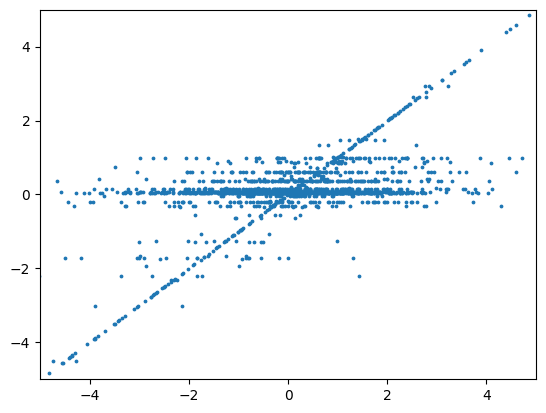

In [114]:
plt.scatter(df.change_tomorrow, predictions, s=3)
plt.xlim(-5,5)
plt.ylim(-5,5)